In [1]:
import pandas as pd
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Computer Modern Serif"]
})
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import RBF, Quadratic, Linear, Matern
from DynamicalSystems.reduced_rank_regression import KoopmanRegression
from DynamicalSystems.utils import plot_eigs
import seaborn as sns

def eigenvalues_timescale(eigenvalues, stride, timestep):
    eps = 1e-12
    data = []
    for ev in eigenvalues:
        decay_length = np.around((-np.log(np.abs(ev))**-1)*stride*timestep, decimals = 2)
        if np.abs(np.imag(ev)) < eps:
            #Real eigenvalue
            freq = None
            data.append((decay_length, freq))
        else:
            #Imaginary eigenvalue
            freq = np.around(2*np.pi*(np.angle(ev)**-1)*stride*timestep, decimals=2)
            data.append((decay_length, freq))
    return data

def print_timescale(eigenvalues, stride, timestep, units=''):
    data = eigenvalues_timescale(eigenvalues, stride, timestep) 
    col_width = max(len(str(_x[0]) + " " + units) for _x in data) + 2  # padding
    for x in data:
        if x[1] == None:
            print(f"Decay:{x[0]} {units}")
        elif x[1] <= 0:
            pass
        else:
            a = str(x[0]) + " " + units
            print("Decay: " + a.ljust(col_width) + f"Frequency: {x[1]} {units}")

#### Standardizing dataset

In [2]:
df_pd = pd.read_pickle("full_dataframe").interpolate().dropna()
#Get stations and measurements 
stations = set()
measurements = set()
for col in df_pd.columns:
    meas, stat = col.split("_")
    measurements.add(meas)
    stations.add(stat)

standardizing_parameters = dict() # (std, mean)

for m in measurements:
    std = df_pd.filter(regex= m + "_*").std().mean()
    mean = df_pd.filter(regex= m + "_*").mean().mean()
    standardizing_parameters[m] = (std, mean)

def scale(x, m, s):
    return (x - m)/s

def unscale(x, m, s):
    return x*s + m

#Scale measurements
df = dict()
for m in measurements:
    df[m] = (list(df_pd.filter(regex= m + "_*").columns), df_pd.filter(regex= m + "_*").apply(lambda x: scale(x, standardizing_parameters[m][1], standardizing_parameters[m][0])).to_numpy())

#### Selecting timestep, kernel, desired rank & regularizer

In [3]:
def extract_windows_vectorized(array,sub_window_size):
    #Sliding window every timestep, adapted from https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
    max_time = array.shape[0] - sub_window_size
    sub_windows = (
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    res = array[sub_windows]
    return res.reshape(res.shape[0], -1)

def subsample_data(df, n_timesteps, shift=0):
    #Select 1 data point every n_timesteps
    raised_exception = False
    dataset_indexes = []
    i = 0
    while not raised_exception:
        try:
            df[shift + i*n_timesteps]
            dataset_indexes.append(shift + i*n_timesteps)
            i += 1
        except Exception as e:
            raised_exception = True
    return df[np.array(dataset_indexes)]

def get_training_dataset(df, measurements, n_timesteps = None, history = None, average = False, shift = 0):
    if average:
        _cols = [m + "_mean" for m in measurements]
        _df = np.hstack([df[m][1].mean(axis=1)[:, np.newaxis] for m in measurements])
    else:
        _cols = [elem for sublist in [df[m][0] for m in measurements] for elem in sublist]
        _df = np.hstack([df[m][1] for m in measurements])
    #Applying subsampling and then sliding window
    if n_timesteps is not None:
        _df = subsample_data(_df, n_timesteps, shift = shift)
    if history is not None:
        _df = extract_windows_vectorized(_df, history)
        _cols_old = _cols
        _cols = [_cols_old[i] + " + " + str(j) for j in range(history) for i in range(len(_cols_old))]
    return _df, _cols

In [133]:
n_timesteps = 3 #In hours
regularizer = 1e-7
history = 9
average = False
_df, _cols = get_training_dataset(df, measurements, n_timesteps = n_timesteps, history = history, average = average)
l = np.float32(np.sqrt(_df.shape[1]))*3
X, Y = _df[:-1], _df[1:]
nu = 0.5
kernel = Matern(nu = nu, length_scale=l)
#kernel = Linear(coef0=0.)
num_samples = 3000
rank = 10
X_train, Y_train = X[:num_samples], Y[:num_samples]

In [134]:
K = KoopmanRegression(X_train, Y_train, kernel, regularizer, rank=rank, center_kernel=False, backend='cpu')

INIT: Computing low-rank-projection


In [135]:
#If history, mask everything but the last history timesteps
def mask_old_timesteps(array, measurement, history):
    idxs = []
    num_cols = array.shape[1]
    num_features = int(num_cols/history)
    for i,x in enumerate(_cols):
        if measurement in x:
            if i >= num_features*int(history - 1):
                idxs.append(i)
    return array[:, idxs]

### Forecasting

In [8]:
idx_0 = num_samples - 25
x_pred = [Y[idx_0]]
n_steps = 75
for _ in range(n_steps):
    x_pred.append(K.forecast(x_pred[-1]))
x_pred = np.array(x_pred)
x_true = Y[idx_0:(idx_0 + n_steps  +1)]

/tmp/ipykernel_2089741/2674029267.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_pred = np.array(x_pred)


In [9]:
measurement = 'DEWP'
m_true = mask_old_timesteps(x_true, measurement, history)
m_pred = mask_old_timesteps(x_pred, measurement, history)
hours = np.linspace(0, n_steps*n_timesteps, n_steps + 1)
plt.plot(hours, m_true, 'g-', alpha = 0.3, lw=0.3)
plt.plot(hours, m_true.mean(axis=1), 'g-', label='True ' + measurement)
plt.plot(hours, m_pred, 'r-', alpha = 0.3, lw=0.3)
plt.plot(hours, m_pred.mean(axis=1), 'r-.', label='Predicted ' + measurement)
plt.axvline(x=n_timesteps*25, color='k', linestyle='--', lw=1, alpha = 0.5)
plt.text(x=n_timesteps*25 + 3, y = -2, s='UNSEEN DATA', rotation='vertical', fontsize=8, verticalalignment='bottom')
plt.ylabel(measurement)
plt.xlabel('Hours')
plt.margins(0)
plt.legend(frameon=False)
#plt.savefig("figs/predictions_" + measurement + ".pdf", bbox_inches='tight')

IndexError: tuple index out of range

### Eigenvalue approximation

In [139]:
#Full approximation
dim = K.K_X.shape[0]
eigs_full = scipy.linalg.eigvals(K.K_YX, K.K_X + dim*regularizer*np.eye(dim))
#Reduced rank regression
eigs_RRR, _, _ = K.eig() 
#Dynamic Mode decomposition
U_r, S_r, V_r = np.linalg.svd(K.K_X)
K_r = U_r[:, :rank]@np.diag(S_r[:rank])@V_r[:rank, :]
eigs_DMD = scipy.linalg.eigvals(scipy.linalg.pinv(K_r)@K.K_YX)

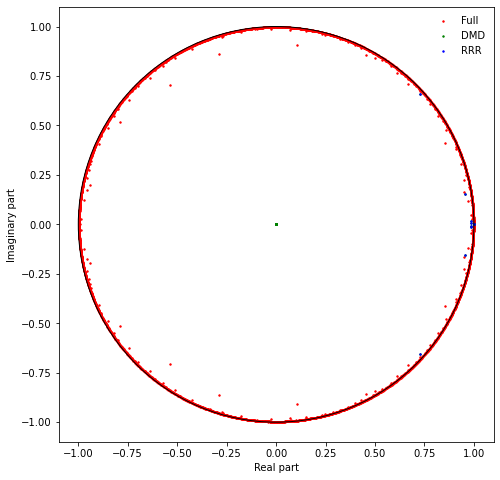

In [140]:
fig, ax = plot_eigs([eigs_full, eigs_DMD, eigs_RRR], labels=['Full', 'DMD', 'RRR'])
#ax.set_xlim(0.7,1)

In [141]:
print_timescale(eigs_RRR, n_timesteps, 1, 'Hours')

Decay: 148.05 Hours     Frequency: 25.66 Hours
Decay: 84.69 Hours      Frequency: 117.3 Hours
Decay: 214.14 Hours     Frequency: 1184.32 Hours
Decay:116675.96 Hours
Decay:1684.66 Hours
Decay: 188.18 Hours     Frequency: 2942.08 Hours


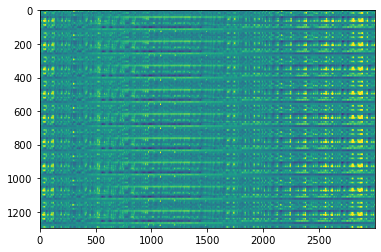

In [142]:
plt.imshow(X_train.T,aspect='auto', vmin=-3, vmax=3)

### Mode decomposition

In [143]:
modes = K.modes()
eigs = K.eigvals()
obs_1 = "PM2.5"
obs_2 = "DEWP"
modes_1 = mask_old_timesteps(modes, obs_1, history)
modes_2 = mask_old_timesteps(modes, obs_2, history)
modes_1_avg = modes_1.mean(axis=1)
modes_2_avg = modes_2.mean(axis=1)
c_1 = 'r'
c_2 = 'b'

Text(0.5, 1.0, 'Similar amplitudes suggest similar modes')

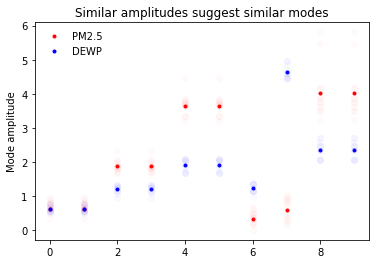

In [144]:
plt.plot(np.abs(modes_1),c_1+'o', alpha=0.02);
plt.plot(np.abs(modes_2),c_2+'o', alpha=0.02);
plt.plot(np.abs(modes_1_avg),c_1+'.', label=obs_1);
plt.plot(np.abs(modes_2_avg),c_2+'.', label=obs_2);
plt.legend(frameon=False)
plt.ylabel("Mode amplitude")
plt.title("Similar amplitudes suggest similar modes")

In [177]:
def causality_rel(idx, eigs, modes_1_avg, modes_2_avg, obs_1, obs_2, stride, n_timesteps, units):
    dphi = np.sign(eigs.imag)*(np.angle(modes_2_avg) - np.angle(modes_1_avg))
    dphi = dphi - np.pi*2*np.floor((dphi + np.pi)/(2*np.pi))
    
    if np.abs(dphi[idx]) < 1e-12:
        print(f"{obs_1} and {obs_2} are in phase")
    elif np.abs(np.abs(dphi[idx]) - np.pi) < 1e-12:
        print(f"{obs_1} and {obs_2} are anti-phase")
    elif dphi[idx] > 0:
        dt = np.around(stride*n_timesteps*dphi[idx]/np.abs(np.angle(eigs[idx])), decimals=2)
        print(f"{obs_2} comes first than {obs_1} by {dt} {units}")
    else:
        dt = np.around(stride*n_timesteps*dphi[idx]/np.abs(np.angle(eigs[idx])), decimals=2)
        print(f"{obs_1} comes first than {obs_2} by {-dt} {units}")
    return dphi

In [191]:
idx = 0
dphi = causality_rel(2, eigs, modes_1_avg, modes_2_avg, obs_1, obs_2, 1, n_timesteps, 'Hours')

DEWP comes first than PM2.5 by 0.81 Hours


Text(0.5, 0, 'Time')

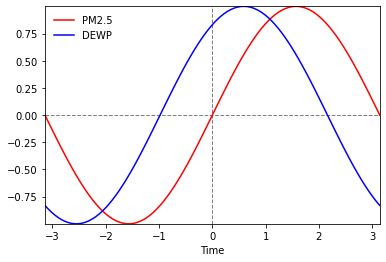

In [193]:
x = np.linspace(-np.pi, np.pi ,100)
phi = dphi[idx]
plt.axvline(x=0, color='k', linestyle='--', lw=1, alpha = 0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=1, alpha = 0.5)
plt.plot(x, np.sin(x), c_1, label=obs_1)
plt.plot(x, np.sin(phi + x), c_2, label=obs_2)
plt.legend(frameon=False)
plt.margins(0)
plt.xlabel("Time")